# Постановка задачи

Предсказать цену акций (https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv) с помощью LSTM.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Импортируем данные

In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')

In [14]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


## Предобработка данных

In [35]:
df_new = df['Close'] # создаём новый датасет с данными по столбцу Close

In [36]:
df_new

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

In [37]:
df_new = df_new.values # переводим новый датасет (сейчас он записан в виде DataFrame) в тип numpy

In [38]:
type(df_new)

numpy.ndarray

In [39]:
df_new = df_new.astype('float32') # приводим значения массива к вещественным числам

In [31]:
df_new

array([233.75, 233.25, 234.25, ..., 120.65, 120.9 , 121.55], dtype=float32)

In [49]:
df_new = df_new.reshape(-1, 1)
df_new

array([[233.75],
       [233.25],
       [234.25],
       ...,
       [120.65],
       [120.9 ],
       [121.55]], dtype=float32)

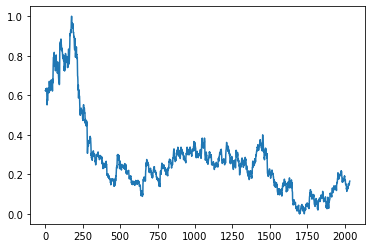

In [79]:
plt.plot(df_new) # отображаем данные на графике
plt.show()

In [50]:
scaler = MinMaxScaler(feature_range=(0, 1)) # сжимаем данные от 0 до 1, чтобы нейросети было проще обрабатывать данные
df_new = scaler.fit_transform(df_new)

In [52]:
df_new

array([[0.62418294],
       [0.6221405 ],
       [0.6262255 ],
       ...,
       [0.16217321],
       [0.16319445],
       [0.16584969]], dtype=float32)

In [54]:
train_size = int(len(df_new) * 0.67) # задаём тренировочный массив (2/3 от общего числа данных)
test_size = len(df_new) - train_size # задаём массив тестовых данных
train, test = df_new[:train_size, :], df_new[train_size:,:] # задаём переменные train и test
print(len(train), len(test))

1363 672


## Сбор и обработка features и labels

In [56]:
def create_dataset(df_new, look_back): # look_back - ширина окна (window) - количество месяцев, которое мы берём (features), чтобы предсказать значение в последующем месяце (labels)
    dataX, dataY = [], [] # создаём отдельные массивы (features и labels)
    for i in range(len(df_new)-look_back-1):
        a = df_new[i:(i+look_back), 0] # на каждой итерации берётся значение датасете от текущего месяца (i) до значения окна (i+look_back)
        dataX.append(a) # добавляем фичу (a) в dataX
        dataY.append(df_new[i + look_back, 0]) # добавляем лейбл (df_new[i + look_back, 0]) - следующее значение месяца, который идёт после окна, которое мы берём
    return np.array(dataX), np.array(dataY) # возвращаем массивы dataX и dataY как массивы numpy

## Создание модели

In [67]:
look_back = 2
trainX, trainY = create_dataset(train, look_back) # создаём тренировочный датасет
testX, testY = create_dataset(test, look_back) # создаём тестовый датасет

In [68]:
trainX.shape # смотрим размерность датасета с тренировочными данными

(1360, 2)

In [69]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])) # меняем размерность датасета для сети LSTM
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [70]:
trainX.shape # смотрим размерность датасета с тренировочными данными

(1360, 1, 2)

In [71]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) # добавляем рекуррентный слой LSTM
model.add(Dense(1)) # добавляем полносвязный слой Dense

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4)                 112       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.compile(loss='mean_squared_error', optimizer='adam') # компилируем модель

In [74]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1360/1360 - 5s - loss: 0.0119 - 5s/epoch - 3ms/step
Epoch 2/100
1360/1360 - 3s - loss: 2.8138e-04 - 3s/epoch - 2ms/step
Epoch 3/100
1360/1360 - 3s - loss: 2.8734e-04 - 3s/epoch - 2ms/step
Epoch 4/100
1360/1360 - 3s - loss: 2.8465e-04 - 3s/epoch - 2ms/step
Epoch 5/100
1360/1360 - 3s - loss: 2.9067e-04 - 3s/epoch - 2ms/step
Epoch 6/100
1360/1360 - 3s - loss: 2.8524e-04 - 3s/epoch - 2ms/step
Epoch 7/100
1360/1360 - 3s - loss: 2.8436e-04 - 3s/epoch - 2ms/step
Epoch 8/100
1360/1360 - 3s - loss: 2.8338e-04 - 3s/epoch - 2ms/step
Epoch 9/100
1360/1360 - 3s - loss: 2.9197e-04 - 3s/epoch - 2ms/step
Epoch 10/100
1360/1360 - 3s - loss: 2.8577e-04 - 3s/epoch - 2ms/step
Epoch 11/100
1360/1360 - 3s - loss: 2.7597e-04 - 3s/epoch - 2ms/step
Epoch 12/100
1360/1360 - 3s - loss: 2.6716e-04 - 3s/epoch - 2ms/step
Epoch 13/100
1360/1360 - 3s - loss: 2.7589e-04 - 3s/epoch - 2ms/step
Epoch 14/100
1360/1360 - 3s - loss: 2.6870e-04 - 3s/epoch - 2ms/step
Epoch 15/100
1360/1360 - 3s - loss: 2.7395e-04 

In [75]:
# делаем предсказание
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

21/21 [==============================] - 0s 2ms/step


In [76]:
# делаем обратную трансформацию, чтобы привести данные к изначальному виду
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

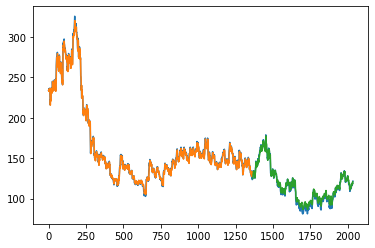

In [78]:
# сдвиг предсказаний по обучению на тренировочном датасете
trainPredictPlot = np.empty_like(df_new)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# сдвиг предсказаний по обучению на тестовом датасете
testPredictPlot = np.empty_like(df_new)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict
# построение графика исходных данных (синяя линия) и предсказанных прогнозов на тренировочном (оранжевая линия) и тестовом (зелёная линия) датасетах
plt.plot(scaler.inverse_transform(df_new))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()